In [ ]:
#!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2

In [ ]:
!nvidia-smi

Sat Oct 29 15:53:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install syft==0.2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

import syft as sy
from syft.frameworks.torch.fl import FederatedDataset, FederatedDataLoader, BaseDataset, utils

from torchvision import transforms, datasets
from torch.utils import data as torch_data

from torch.utils.data import Dataset

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch import flatten

import math
import logging

import os
import random
import sys
from tqdm import tqdm
import cv2
#import numpy as np

import logging

import matplotlib.pyplot as plt

from google.colab import drive


In [ ]:
#drive.mount("my-drive")
from google.colab import drive
drive.mount('/content/drive')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp /content/my-drive/MyDrive/Chest_Dataset.zip /media/
#!unzip /media/Chest_Dataset.zip -d /media/

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np

In [ ]:
def get_training_data(data_dir, labels):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))/255. # Reshaping images to preferred size
                data.append([resized_arr.astype(np.float32), class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
class Dataset_V2(torch_data.Dataset):
  def __init__(self, data, transforms):
    self.transform = transforms
    self.x = data[:,0]
    self.y = data[:,1]

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.transform(self.x[idx]) , self.y[idx]

In [ ]:
#classes = ['PNEUMONIA', 'NORMAL', 'COVID', 'LUNG_OPACITY']
classes = ['COVID', 'Lung_Opacity', 'Normal']
img_size = 128
num_class = 3
batch_size = 8
num_clients = 10
num_clients_round = 10
#data_dir = "/media/Chest_Dataset/"
data_dir = "/content/drive/MyDrive/DL_Scenario2/"

#data_dir = "/media/Chest_Dataset/"

In [ ]:
data = get_training_data(data_dir, classes)

100%|██████████| 1000/1000 [00:03<00:00, 269.41it/s]


In [ ]:
class ResNet50(nn.Module):
  def __init__(self, pretrain=True):
    super(ResNet50, self).__init__()

    self.conv1 = nn.Conv2d(1, 48, kernel_size=7, stride=2, padding=1)
    self.conv2 = nn.Conv2d(48, 64, kernel_size=5, stride=2, padding=1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    self.bn1 = nn.BatchNorm2d(48)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(128)
    self.bn5 = nn.BatchNorm2d(256)

    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.1)

    self.fc1 = nn.Linear(3*3*256, 128)
    #self.fc2 = nn.Linear(128,4)
    #self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 32)
    self.fc5 = nn.Linear(32, 4)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.bn1(x)
    #x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)
    #x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.dropout(x) #do1
    x = self.pool(x)

    x = F.relu(self.conv4(x))
    x = self.bn4(x)
    x = self.dropout(x) #do2
    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = self.bn5(x)
    x = self.dropout(x) #do3
    x = self.pool(x)

    x = flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x) #do4
    x = F.relu(self.fc4(x))
    x = self.dropout(x) #do5
    #x = F.relu(self.fc4(x))
    x = self.fc5(x)

    return x


In [ ]:
test_lossess = []
train_lossess = []
def federated_train(network, epochs, optimizer, criterion, clients, loaders, test_loader, num_clients_round, num_local_epochs=2):

  total_batch_print = 100
  central_model = network

  for epoch in range(epochs):

    central_model.train()

    selected_clients = random_select_clients(clients, num_clients_round)

    correct = 0
    epoch_loss = 0.0

    for client in selected_clients:
      #model_client = Net().to(device)
      model_client = ResNet50().to(device)
      model_client.load_state_dict(central_model.state_dict())

      client_loss = 0.0

      models = []
      for i in range(num_local_epochs):
        for batch_idx, (x, y) in enumerate(loaders[client]):
          optimizer = torch.optim.Adadelta(model_client.parameters(), lr = 0.005)

          x, y = x.to(device), y.to(device)

          output = model_client(x)
          loss = criterion(output, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(y.view_as(pred)).sum().item()

          client_loss += loss.item()
          epoch_loss += loss.item() / (len(loaders[client]) * num_clients_round) #total_batch


      print('Train Epoch: {}, Client: {} \tLoss: {:.6f}'.format(
              epoch, client, client_loss / (len(loaders[client])*num_local_epochs)))

      models.append(model_client)

    train_lossess.append((100. * correct) / (len(loaders[client])*loaders[client].batch_size*num_clients_round*num_local_epochs))
    print('\nTrain Epoch: {} \tLoss: {:.6f} Train Accuracy: {}/{} ({:.2f}%)'.format(
          epoch, epoch_loss, correct, len(loaders[client])*loaders[client].batch_size*num_clients_round * num_local_epochs,
          (100. * correct) / (len(loaders[client])*loaders[client].batch_size*num_clients_round*num_local_epochs)))


    central_model.load_state_dict(utils.federated_avg(dict(enumerate(models))).state_dict())


    central_model.eval()
    correct = 0

    epoch_loss = 0.0

    for batch_idx, (x, y) in enumerate(test_loader):
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      output = central_model(x)
      loss = criterion(output, y)

      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(y.view_as(pred)).sum().item()

      epoch_loss += loss.item() / len(test_loader)

    test_lossess.append((100. * correct) / (len(test_loader)*test_loader.batch_size))
    print('Test Loss: {:.6f} Test Accuracy: {}/{} ({:.2f}%)\n'.format(
          epoch_loss, correct, len(test_loader)*test_loader.batch_size, (100. * correct) / (len(test_loader)*test_loader.batch_size)))

In [ ]:
def test(network, test_loader):
  network.eval()
  test_loss = 0
  correct = 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
      for x, y in test_loader:
          x, y = x.to(device), y.to(device)
          output = network(x)
          test_loss += criterion(output, y).item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(y.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader) * test_loader.batch_size,
      100. * correct / (len(test_loader)* test_loader.batch_size)))

In [ ]:
np.random.shuffle(data)
train_set, test_set = np.split(data,[int(.9*len(data))])

In [ ]:
transform_train = transforms.Compose([transforms.ToTensor()])#,transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
                                      #transforms.RandomRotation(degrees = (-10,10), fill=(0,)), transforms.ToTensor()])
transform_test  = transforms.Compose([transforms.ToTensor()])

In [ ]:
ds_train = Dataset_V2(train_set, transform_train)
ds_test  = Dataset_V2(test_set, transform_test)

In [ ]:
def create_client_devices(num_client):
  clients = []

  for i in range(num_client):
    clients.append("VW_" + str(i))

  return clients

In [ ]:
def random_select_clients(clients, number):
  return random.sample(clients, number)

In [ ]:
def split_dataset_toClients(train_set, clients, batch_size):
  loaders = {}
  len_train_set = len(train_set)
  len_client_set = int(len_train_set / len(clients))

  for i, client in enumerate(clients):

    dataset = Dataset_V2(train_set[i*len_client_set:(i+1)*len_client_set],transform_train)
    loaders[client] = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

  return loaders

In [ ]:
clients = create_client_devices(num_clients)

In [ ]:
loaders = split_dataset_toClients(train_set, clients, batch_size)

In [ ]:
logger = logging.getLogger(__name__)

In [ ]:
test_loader = torch_data.DataLoader(ds_test, shuffle=False)

In [ ]:
central_model = ResNet50().to(device)

In [ ]:
optimizer = torch.optim.Adadelta(central_model.parameters(), lr = 0.005) #lr = 0.001
criterion = nn.CrossEntropyLoss()

In [ ]:
test_lossess = []

In [ ]:
#### TRY AGAIN

In [ ]:
federated_train(central_model, 5, optimizer, criterion, clients, loaders, test_loader, num_clients_round, num_local_epochs=10)

Train Epoch: 0, Client: VW_3 	Loss: 0.898965
Train Epoch: 0, Client: VW_8 	Loss: 0.891210
Train Epoch: 0, Client: VW_2 	Loss: 0.912791
Train Epoch: 0, Client: VW_6 	Loss: 0.861446
Train Epoch: 0, Client: VW_5 	Loss: 0.896542
Train Epoch: 0, Client: VW_7 	Loss: 0.906897
Train Epoch: 0, Client: VW_4 	Loss: 0.884682
Train Epoch: 0, Client: VW_1 	Loss: 0.885145
Train Epoch: 0, Client: VW_0 	Loss: 0.876501
Train Epoch: 0, Client: VW_9 	Loss: 0.890201

Train Epoch: 0 	Loss: 8.904380 Train Accuracy: 18123/27200 (66.63%)
Test Loss: 0.532873 Test Accuracy: 253/300 (84.33%)

Train Epoch: 1, Client: VW_7 	Loss: 0.498940
Train Epoch: 1, Client: VW_8 	Loss: 0.462996
Train Epoch: 1, Client: VW_3 	Loss: 0.460109
Train Epoch: 1, Client: VW_5 	Loss: 0.475303
Train Epoch: 1, Client: VW_1 	Loss: 0.527145
Train Epoch: 1, Client: VW_4 	Loss: 0.455983
Train Epoch: 1, Client: VW_0 	Loss: 0.457950
Train Epoch: 1, Client: VW_2 	Loss: 0.515614
Train Epoch: 1, Client: VW_6 	Loss: 0.492096
Train Epoch: 1, Client:

In [ ]:
test(central_model, test_loader)


Test set: Average loss: 0.2739, Accuracy: 267/300 (89.00%)



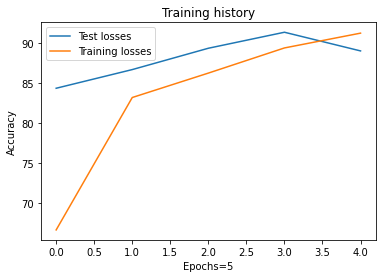

In [ ]:
#Plot the Accuracy Curves
plt.plot(test_lossess, label='Test losses')
plt.plot(train_lossess, label='Training losses')
plt.legend()

# Add title and axis names
plt.title('Training history')
plt.xlabel('Epochs=5')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
federated_train(central_model, 20, optimizer, criterion, clients, loaders, test_loader, num_clients_round, num_local_epochs=10)

Train Epoch: 0, Client: VW_3 	Loss: 0.786687
Train Epoch: 0, Client: VW_7 	Loss: 0.760779
Train Epoch: 0, Client: VW_1 	Loss: 0.739944
Train Epoch: 0, Client: VW_4 	Loss: 0.741458
Train Epoch: 0, Client: VW_0 	Loss: 0.746530
Train Epoch: 0, Client: VW_5 	Loss: 0.743605
Train Epoch: 0, Client: VW_2 	Loss: 0.763117
Train Epoch: 0, Client: VW_9 	Loss: 0.718193
Train Epoch: 0, Client: VW_6 	Loss: 0.765957
Train Epoch: 0, Client: VW_8 	Loss: 0.776147

Train Epoch: 0 	Loss: 7.542416 Train Accuracy: 19475/27200 (71.60%)
Test Loss: 0.527105 Test Accuracy: 245/300 (81.67%)

Train Epoch: 1, Client: VW_3 	Loss: 0.508153
Train Epoch: 1, Client: VW_4 	Loss: 0.448066
Train Epoch: 1, Client: VW_5 	Loss: 0.465221
Train Epoch: 1, Client: VW_6 	Loss: 0.495831
Train Epoch: 1, Client: VW_2 	Loss: 0.477910
Train Epoch: 1, Client: VW_9 	Loss: 0.414564
Train Epoch: 1, Client: VW_7 	Loss: 0.486047
Train Epoch: 1, Client: VW_0 	Loss: 0.468120
Train Epoch: 1, Client: VW_8 	Loss: 0.414781
Train Epoch: 1, Client:

In [ ]:
test(central_model, test_loader)


Test set: Average loss: 0.1772, Accuracy: 285/300 (95.00%)



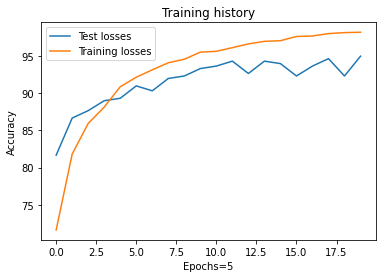

In [ ]:
#Plot the Accuracy Curves
plt.plot(test_lossess, label='Test losses')
plt.plot(train_lossess, label='Training losses')
plt.legend()

# Add title and axis names
plt.title('Training history')
plt.xlabel('Epochs=5')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
federated_train(central_model, 50, optimizer, criterion, clients, loaders, test_loader, num_clients_round, num_local_epochs=10)

Train Epoch: 0, Client: VW_5 	Loss: 0.828647
Train Epoch: 0, Client: VW_4 	Loss: 0.889610
Train Epoch: 0, Client: VW_3 	Loss: 0.817951
Train Epoch: 0, Client: VW_9 	Loss: 0.796438
Train Epoch: 0, Client: VW_6 	Loss: 0.809656
Train Epoch: 0, Client: VW_8 	Loss: 0.857155
Train Epoch: 0, Client: VW_7 	Loss: 0.797023
Train Epoch: 0, Client: VW_1 	Loss: 0.851475
Train Epoch: 0, Client: VW_0 	Loss: 0.908200
Train Epoch: 0, Client: VW_2 	Loss: 0.897638

Train Epoch: 0 	Loss: 8.453794 Train Accuracy: 17688/27200 (65.03%)
Test Loss: 0.585090 Test Accuracy: 230/300 (76.67%)

Train Epoch: 1, Client: VW_4 	Loss: 0.538334
Train Epoch: 1, Client: VW_8 	Loss: 0.485007
Train Epoch: 1, Client: VW_2 	Loss: 0.413111
Train Epoch: 1, Client: VW_1 	Loss: 0.490171
Train Epoch: 1, Client: VW_0 	Loss: 0.521590
Train Epoch: 1, Client: VW_9 	Loss: 0.429604
Train Epoch: 1, Client: VW_3 	Loss: 0.442460
Train Epoch: 1, Client: VW_6 	Loss: 0.442907
Train Epoch: 1, Client: VW_7 	Loss: 0.410189
Train Epoch: 1, Client:

In [ ]:
test(central_model, test_loader)


Test set: Average loss: 0.4918, Accuracy: 275/300 (91.67%)



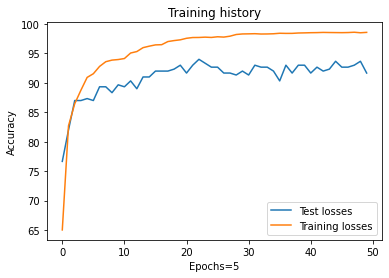

In [ ]:
#Plot the Accuracy Curves
plt.plot(test_lossess, label='Test losses')
plt.plot(train_lossess, label='Training losses')
plt.legend()

# Add title and axis names
plt.title('Training history')
plt.xlabel('Epochs=5')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
federated_train(central_model, 70, optimizer, criterion, clients, loaders, test_loader, num_clients_round, num_local_epochs=10)

Train Epoch: 0, Client: VW_2 	Loss: 0.894198
Train Epoch: 0, Client: VW_8 	Loss: 0.881745
Train Epoch: 0, Client: VW_4 	Loss: 0.853438
Train Epoch: 0, Client: VW_3 	Loss: 0.883118
Train Epoch: 0, Client: VW_5 	Loss: 0.854065
Train Epoch: 0, Client: VW_6 	Loss: 0.894226
Train Epoch: 0, Client: VW_1 	Loss: 0.811000
Train Epoch: 0, Client: VW_7 	Loss: 0.824535
Train Epoch: 0, Client: VW_9 	Loss: 0.852688
Train Epoch: 0, Client: VW_0 	Loss: 0.851877

Train Epoch: 0 	Loss: 8.600889 Train Accuracy: 19225/27200 (70.68%)
Test Loss: 0.669760 Test Accuracy: 211/300 (70.33%)

Train Epoch: 1, Client: VW_9 	Loss: 0.515650
Train Epoch: 1, Client: VW_0 	Loss: 0.432385
Train Epoch: 1, Client: VW_5 	Loss: 0.493584
Train Epoch: 1, Client: VW_3 	Loss: 0.545318
Train Epoch: 1, Client: VW_2 	Loss: 0.552695
Train Epoch: 1, Client: VW_4 	Loss: 0.473954
Train Epoch: 1, Client: VW_8 	Loss: 0.531901
Train Epoch: 1, Client: VW_7 	Loss: 0.504123
Train Epoch: 1, Client: VW_6 	Loss: 0.550224
Train Epoch: 1, Client:

In [ ]:
test(central_model, test_loader)


Test set: Average loss: 0.7283, Accuracy: 268/300 (89.33%)



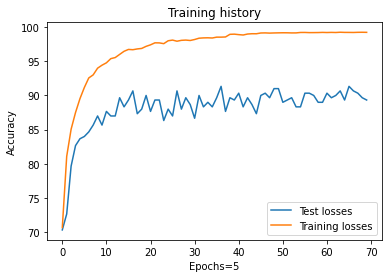

In [ ]:
#Plot the Accuracy Curves
plt.plot(test_lossess, label='Test losses')
plt.plot(train_lossess, label='Training losses')
plt.legend()

# Add title and axis names
plt.title('Training history')
plt.xlabel('Epochs=5')
plt.ylabel('Accuracy')
plt.show()